this script creates graphs which compare changes in vulnerability functions
when retrofit is applied
mostly around changes in damage state

In [126]:
%matplotlib inline

import os 
import sys
from os.path import join as pjoin
import numpy as np
import pandas as pd
from scipy.integrate import simpson
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

import seaborn as sns


In [127]:
#some stuff for graphs, maybe needed don't know
sns.set_context('talk',font_scale=1.5)
sns.set_style('ticks')

import and manipulate data

In [128]:
# agg data
No_retro = pd.read_csv(r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\8. USERS\u02618\retrofit\None\004-08495\QFES_004-08495_agg.csv")
Retrofit = pd.read_csv(r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\8. USERS\u02618\retrofit\Retrofit5\004-08495\QFES_004-08495_agg.csv")
# unit level data
No_retro_all = pd.read_csv(r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\8. USERS\u02618\retrofit\None\004-08495\QFES_004-08495.csv")
Retrofit_all = pd.read_csv(r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\8. USERS\u02618\retrofit\Retrofit5\004-08495\QFES_004-08495.csv")

# output path
data_path = r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\8. USERS\u02618\retrofit\Comp\test"

In [129]:
# things for figures (change title depending on what comparison is being done)
Title = '5% retrofit uptake'
res = 600
fmt = "png"

In [130]:
#drop some random columns
No_retro_all.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1,inplace=True)
Retrofit_all.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1,inplace=True)

In [131]:
# create a df of SA1 codes with corresponding LGA codes
LGAs = No_retro_all.copy()
LGAs.drop(LGAs.columns.difference(['SA1_CODE','LGA_CODE','LGA_NAME']), axis=1, inplace=True)
LGAs.drop_duplicates(subset=['SA1_CODE'], inplace=True)

In [132]:
# list of the names of the six LGAs in the study region
LGAs_list = ['Noosa (S)','Sunshine Coast (R)','Moreton Bay (R)','Brisbane (C)','Gold Coast (C)','Redland (C)']

In [133]:
# merge the LGA codes with the aggregated data (so that we can select the SA1s that are in the study region)
No_retro = pd.merge(No_retro, LGAs, how='inner', left_on='SA1_CODE_', right_on='SA1_CODE')
Retrofit = pd.merge(Retrofit, LGAs, how='inner', left_on='SA1_CODE_', right_on='SA1_CODE')

In [134]:
# select and keep only the data that is in the six LGs
No_retro = No_retro[No_retro['LGA_NAME'].isin(LGAs_list)]
Retrofit = Retrofit[Retrofit['LGA_NAME'].isin(LGAs_list)]
No_retro_all = No_retro_all[No_retro_all['LGA_NAME'].isin(LGAs_list)]
Retrofit_all = Retrofit_all[Retrofit_all['LGA_NAME'].isin(LGAs_list)]

In [135]:
#drop some columns that will be duplicates
Retrofit_all.drop(Retrofit_all.columns.difference(['index','WIND_VULNERABILITY_FUNCTION_ID','structural','structural_loss','Damage state']), axis=1, inplace=True)

In [136]:
# add prefixes to the datasets so that when they are merged they can be identified
# "none_" - no retrofit, "retro_" - retrofit functions used
columns = list(No_retro.columns)
columns[2:] = ["none_" + c for c in No_retro.columns][2:]
No_retro.columns = columns

columns = list(Retrofit.columns)
columns[2:] = ["retro_" + c for c in Retrofit.columns][2:]
Retrofit.columns = columns

columns = list(No_retro_all.columns)
columns[2:] = ["none_" + c for c in No_retro_all.columns][2:]
No_retro_all.columns = columns

columns = list(Retrofit_all.columns)
columns[:] = ["retro_" + c for c in Retrofit_all.columns][:]
Retrofit_all.columns = columns

In [137]:
# merge the two agg datasets and the two unit level datasets
Retro_comp = pd.merge(No_retro, Retrofit,how='inner',on='SA1_CODE_')
Retro_comp_all = pd.merge(No_retro_all, Retrofit_all,how='inner',left_index=True,right_index=True)

In [138]:
# dropping more columns that won't be used
Retro_comp.drop(['FID_x','FID_y'], axis=1,inplace=True)

In [139]:
# calculate differences in values between retrofit and no retrofit data
Retro_comp['dif_structural_mean'] = Retro_comp['retro_structural_mean'] - Retro_comp['none_structural_mean']
Retro_comp['dif_structural_max'] = Retro_comp['retro_structural_max'] - Retro_comp['none_structural_max']
Retro_comp['dif_structural_std'] = Retro_comp['retro_structural_std'] - Retro_comp['none_structural_std']
Retro_comp['dif_structural_loss_mean'] = Retro_comp['retro_structural_loss_mean'] - Retro_comp['none_structural_loss_mean']
Retro_comp['dif_structural_loss_sum'] = Retro_comp['retro_structural_loss_sum'] - Retro_comp['none_structural_loss_sum']

In [140]:
# calculate statistics about the differences
Max = Retro_comp['dif_structural_mean'].max()
Min = Retro_comp['dif_structural_mean'].min()
Mean = Retro_comp['dif_structural_mean'].mean()
Mode = Retro_comp['dif_structural_mean'].mode()
Std = Retro_comp['dif_structural_mean'].std()

In [141]:
# define damage state bins
# sort retro and no retro data into damagestate bins
# create a new column for difference in damage state
# if damage state is the same then false, if damage state has changed then true
DS_bins = [0.0, 0.02, 0.1, 0.2, 0.5, 1.0]
DS_labels = ['Negligible', 'Slight', 'Moderate', 'Extensive', 'Complete']
Retro_comp['none_damage state'] = pd.cut(Retro_comp['none_structural_mean'],DS_bins,right = False,labels = DS_labels)
Retro_comp['retro_damage state'] = pd.cut(Retro_comp['retro_structural_mean'],DS_bins,right = False,labels = DS_labels)
Retro_comp['dif_DS'] = np.where(Retro_comp['none_damage state'] == Retro_comp['retro_damage state'], False, True)

In [142]:
#calculating the difference between the structural loss ratio and if there is a difference in damage state
Retro_comp_all['dif_structural'] = Retro_comp_all['retro_structural'] - Retro_comp_all['none_structural']
Retro_comp_all['dif_structural_loss'] = Retro_comp_all['retro_structural_loss'] - Retro_comp_all['none_structural_loss']
Retro_comp_all['dif_DS'] = np.where(Retro_comp_all['none_Damage state'] == Retro_comp_all['retro_Damage state'], False, True)
Retro_comp_all['dif_struc'] = np.where(Retro_comp_all['dif_structural_loss'] == 0, False, True)

In [143]:
#min, max, ave, etc for change in structural loss ratio (should I also do this for only the buildings which had retrofit functions applied?)
Retro_comp_all.dif_structural = Retro_comp_all.dif_structural.round(2)
min_all = Retro_comp_all['dif_structural'].min()
max_all = Retro_comp_all['dif_structural'].max()
mean_all = Retro_comp_all['dif_structural'].mean()
mode_all = Retro_comp_all['dif_structural'].mode()
std_all = Retro_comp_all['dif_structural'].std()

create figures and tables

In [144]:
# this table shows if the average damage state (aggregated at SA1) changed
damage_state_change_by_SA1 = Retro_comp.groupby(['SA1_CODE_','none_damage state','retro_damage state']).size().reset_index(name='counts')
damage_state_change_by_SA1.to_csv(pjoin(data_path,
                  f"damage_state_change_by_SA1_table_agg.csv"))

In [145]:
# change in average structural loss ratio (aggregated at SA1)
structural_loss_mean_change_by_SA1 = Retro_comp.groupby(['SA1_CODE_','none_structural_mean','retro_structural_mean','dif_structural_mean']).size().reset_index(name='counts')
structural_loss_mean_change_by_SA1.to_csv(pjoin(data_path,
                  f"structural_loss_mean_change_by_SA1_table_agg.csv"))

In [146]:
# count of buildings in each SA1 by change in damage state
damage_state_change_by_SA1 = Retro_comp_all.groupby(['none_SA1_CODE','none_Damage state','retro_Damage state']).size().reset_index(name='counts')
damage_state_change_by_SA1.to_csv(pjoin(data_path,
                  f"damage_state_change_by_SA1_table.csv"))

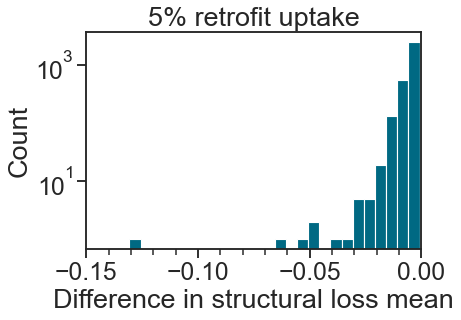

In [147]:
# hist for the change in structural loss ratio for all SA1
sns.histplot(Retro_comp['dif_structural_mean'],binwidth=0.005,facecolor=("#006983"))
plt.title(Title)
plt.minorticks_on()
plt.xlabel('Difference in structural loss mean')
plt.yscale('log')
plt.xlim(-0.15,0)
plt.savefig(pjoin(data_path,
                  f"Difference in structural loss mean for all SA1".format(fmt)),
                  bbox_inches='tight', pad_inches=0.5, dpi=res)

In [148]:
# pivot table of damage state by age (don't think this is needed as vuln func incorperates age)
damage_state_change_by_age = Retro_comp_all.groupby(['none_YEAR_BUILT','none_Damage state','retro_Damage state']).size().reset_index(name='counts')
damage_state_change_by_age.to_csv(pjoin(data_path,
                  f"damage_state_change_by_age_table.csv"))

In [149]:
# pivot table of damage state by vuln func (using the retro vuln func)
damage_state_change_by_dw = Retro_comp_all.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','none_Damage state','retro_Damage state']).size().reset_index(name='counts')
damage_state_change_by_dw.to_csv(pjoin(data_path,
                  f"damage_state_change_by_dw_table.csv"))

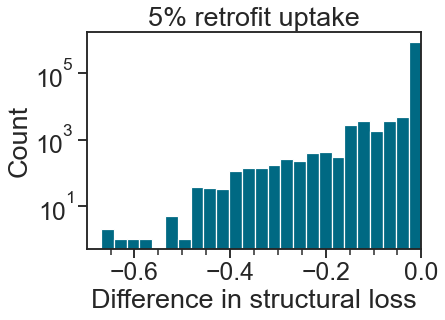

In [150]:
#hist for the change in structural loss ratio for all buildings
sns.histplot(Retro_comp_all['dif_structural'],bins=25,facecolor=("#006983"))
plt.minorticks_on()
plt.title(Title)
plt.xlabel('Difference in structural loss')
plt.yscale('log')
plt.xlim(-0.7,0)
plt.savefig(pjoin(data_path,
                  f"difference_in_structural_loss".format(fmt)),
                  bbox_inches='tight', pad_inches=0.5, dpi=res)

C:\Users\U02618\AppData\Local\Temp\ipykernel_1792\3666514817.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,100000)


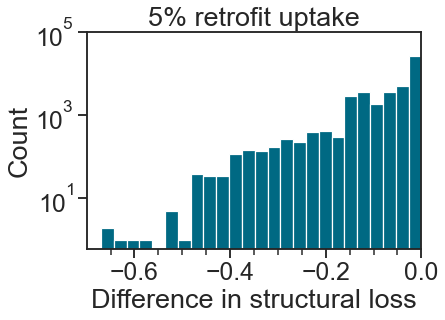

In [151]:
#hist for the change in structural loss ratio, only for buildings which had retrofit functions applied (removing most of the buildings which had no change)
Retro_comp_all_retro_only = Retro_comp_all.loc[((Retro_comp_all['retro_WIND_VULNERABILITY_FUNCTION_ID'].isin(['dw450','dw451','dw452','dw453','dw454','dw455','dw456','dw457','dw458','dw459','dw460','dw461','dw462','dw463','dw464','dw550','dw551','dw552','dw650','dw651','dw652'])))]
dif_structural_loss_mean_nonzero = Retro_comp.loc[~((Retro_comp['dif_structural_loss_mean'] == 0))]

sns.histplot(Retro_comp_all_retro_only['dif_structural'],bins=25,facecolor=("#006983"))
plt.minorticks_on()
plt.title(Title)
plt.xlabel('Difference in structural loss')
plt.yscale('log')
plt.xlim(-0.7,0)
plt.ylim(0,100000)
plt.savefig(pjoin(data_path,
                  f"Difference in structural loss for all eligible buildings".format(fmt)),
                  bbox_inches='tight', pad_inches=0.5, dpi=res)

print this stuff out if interested
it is not used anywhere else

In [152]:
# getting the number of buildings which had a change in structural loss ratio
dif_structural_mean_nonzero_all = Retro_comp_all.loc[~((Retro_comp_all['dif_structural'] == 0))]

# number of SA1 with change in mean structural loss ratio
dif_structural_mean_nonzero = Retro_comp.loc[~((Retro_comp['dif_structural_mean'] == 0))]

# getting the number of buildings which had a change in Damage state
Retro_comp_DS_all = Retro_comp_all.loc[((Retro_comp_all['dif_DS'] == True))]

# getting the number of SA1 which had a change in Damage state
Retro_comp_DS = Retro_comp.loc[((Retro_comp['dif_DS'] == True))]

more figures

In [153]:
# defining and labeling wing bins
wind_bins = [0,10,20,30,40,50,60,70,80,90,100]
wind_labels = ['<10','10 - 20','20 - 30','30 - 40','40 - 50','50 - 60','60 - 70','70 - 80','80 - 90','>=90']
Retro_comp_all['wind_bins'] = pd.cut(Retro_comp_all['none_0.2s gust at 10m height m/s'],wind_bins,right = False,labels = wind_labels)

In [154]:
# pivot table of change in damage state (true or false) by wind bins and change in vuln func
# (in excel 10 - 20 keeps changing to Oct-20 and I don't know how to fix this)
damage_state_change_by_dw_with_wind = pd.pivot_table(Retro_comp_all, values = 'dif_structural' ,index = ['none_WIND_VULNERABILITY_FUNCTION_ID','retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'],columns = 'dif_DS',aggfunc='count')
damage_state_change_by_dw_with_wind.to_csv("damage_state_change_by_dw_with_wind_table.csv")

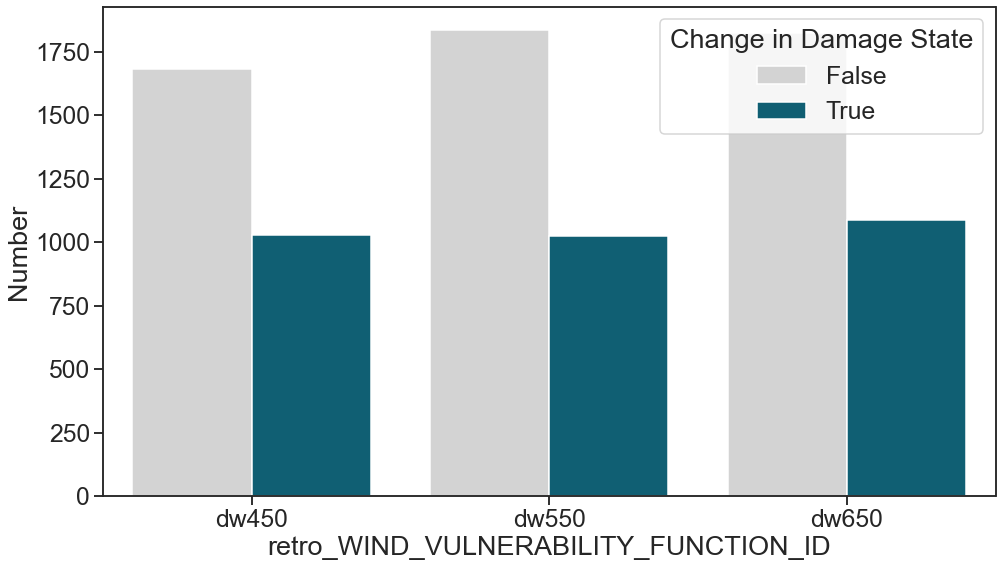

In [155]:
# labels for retrofit vuln functions (legacy retrofit functions)
labels2 = ['dw450','dw550','dw650']

# locating buildings with baseline vuln func dw350
dw350 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw350'))]
dw350 = dw350.loc[~((dw350['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw350'))]
dw350.name = 'dw350'
dw350['plot'] = dw350['retro_WIND_VULNERABILITY_FUNCTION_ID'].astype(str) + ' ' + dw350['wind_bins'].astype(str)

# plot of change in damage state (true or false) for change in vuln func
# dw350 to dw450, dw550, dw650
fig, ax = plt.subplots(figsize=(16,9))
ax = sns.countplot(x='retro_WIND_VULNERABILITY_FUNCTION_ID',order=labels2, data=dw350, hue='dif_DS', palette=["#D3D3D3","#006983"])
ax.legend(title="Change in Damage State", frameon=True, loc=1)
ax.set_ylabel("Number")
fig.savefig(pjoin(data_path,
                  f"change_in_DS_by_vuln_func".format(fmt)), dpi=res)

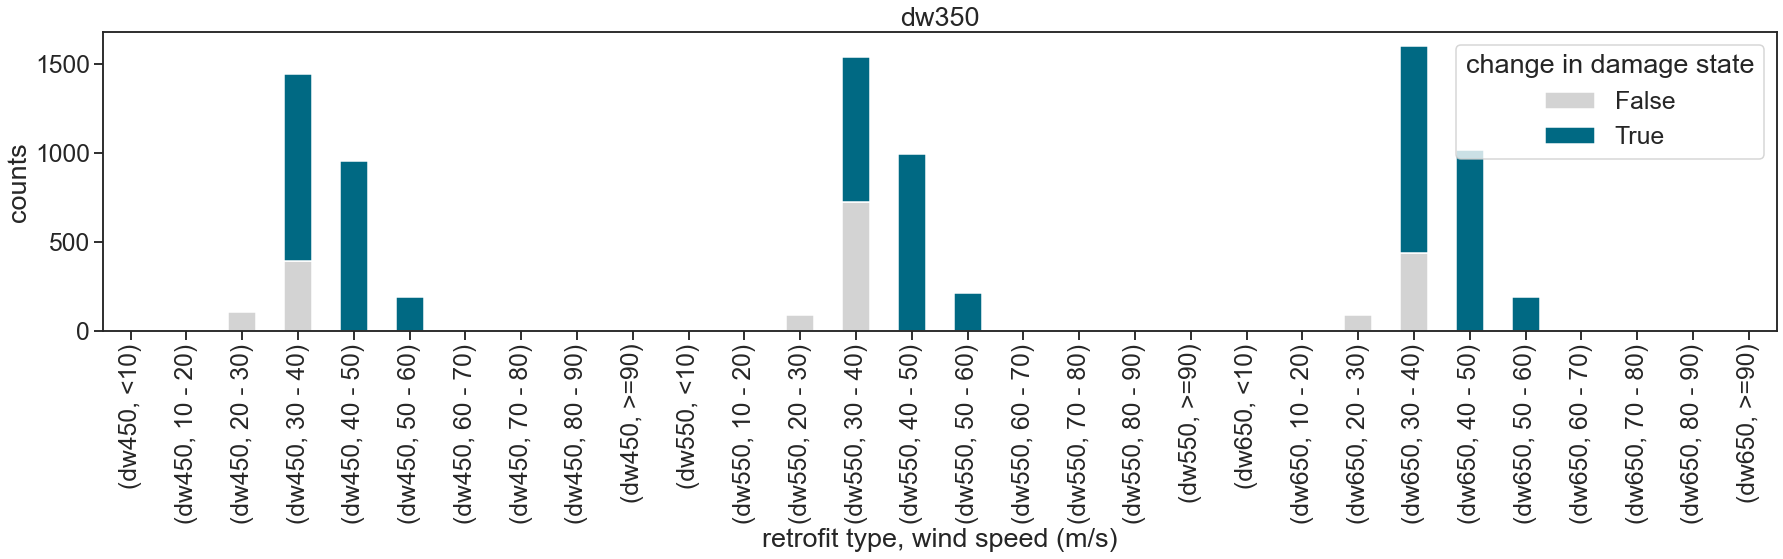

In [156]:
# comparison of change in damage state (true or false) and change in vuln func
# by wind speed
fig,ax = plt.subplots(1,1,figsize=(30,5.5))
dw350_DS_wind = dw350.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index().pivot(columns='dif_struc', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)
dw350_DS_wind.plot(kind='bar',stacked=True, color=["#D3D3D3","#006983"], ax=ax)
plt.title('dw350')
plt.xlabel('retrofit type, wind speed (m/s)')
plt.ylabel('counts')
plt.legend(title='change in damage state')
plt.savefig(pjoin(data_path,
                  f"change_in_DS_by_vuln_func_bins_dw350".format(fmt)), dpi=res, bbox_inches = 'tight')

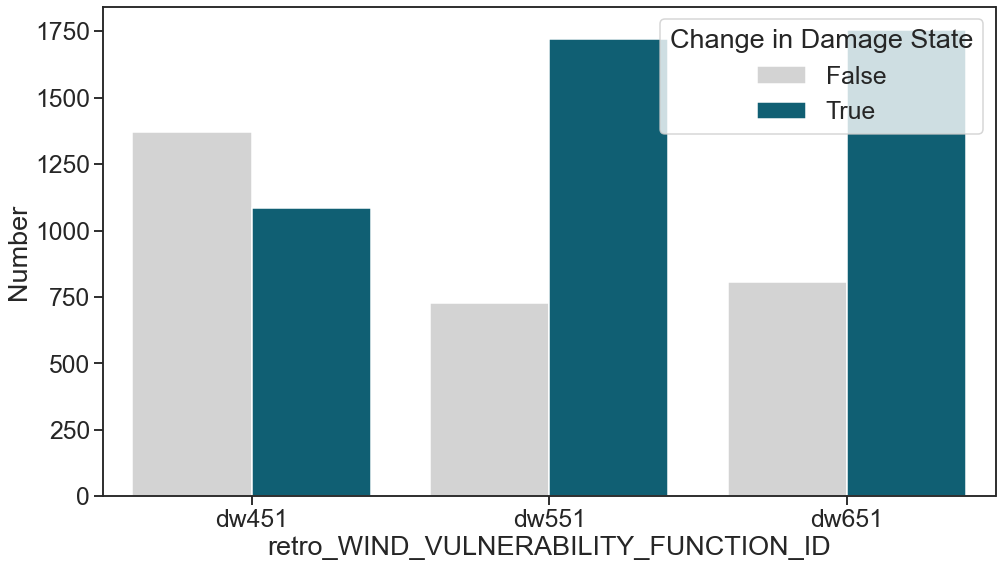

In [157]:
# labels for retrofit vuln functions (legacy retrofit functions)
labels2 = ['dw451','dw551','dw651']

# locating buildings with baseline vuln func dw351
dw351 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw351'))]
dw351 = dw351.loc[~((dw351['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw351'))]
dw351.name = 'dw351'
dw351['plot'] = dw351['retro_WIND_VULNERABILITY_FUNCTION_ID'].astype(str) + ' ' + dw351['wind_bins'].astype(str)

# plot of change in damage state (true or false) for change in vuln func
# dw351 to dw451, dw551, dw651
fig, ax = plt.subplots(figsize=(16,9))
ax = sns.countplot(x='retro_WIND_VULNERABILITY_FUNCTION_ID',order=labels2, data=dw351, hue='dif_DS', palette=["#D3D3D3","#006983"])
ax.legend(title="Change in Damage State", frameon=True, loc=1)
ax.set_ylabel("Number")
fig.savefig(pjoin(data_path,
                  f"change_in_DS_by_vuln_func_2".format(fmt)), dpi=res)

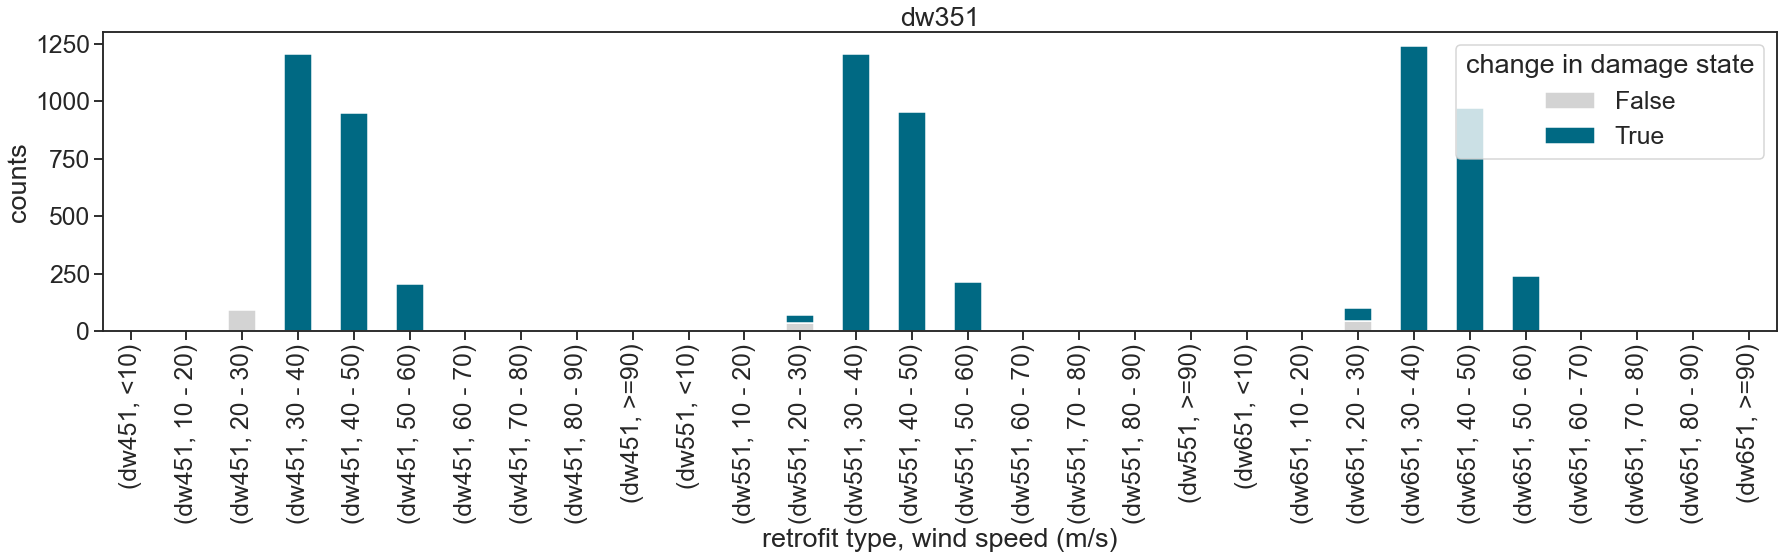

In [158]:
# comparison of change in damage state (true or false) and change in vuln func
# by wind speed
fig,ax = plt.subplots(1,1,figsize=(30,5.5))
dw351_DS_wind = dw351.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index().pivot(columns='dif_struc', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)
dw351_DS_wind.plot(kind='bar',stacked=True, color=["#D3D3D3","#006983"], ax=ax)
plt.title('dw351')
plt.xlabel('retrofit type, wind speed (m/s)')
plt.ylabel('counts')
plt.legend(title='change in damage state')
plt.savefig(pjoin(data_path,
                  f"change_in_DS_by_vuln_func_bins_dw351".format(fmt)), dpi=res, bbox_inches = 'tight')

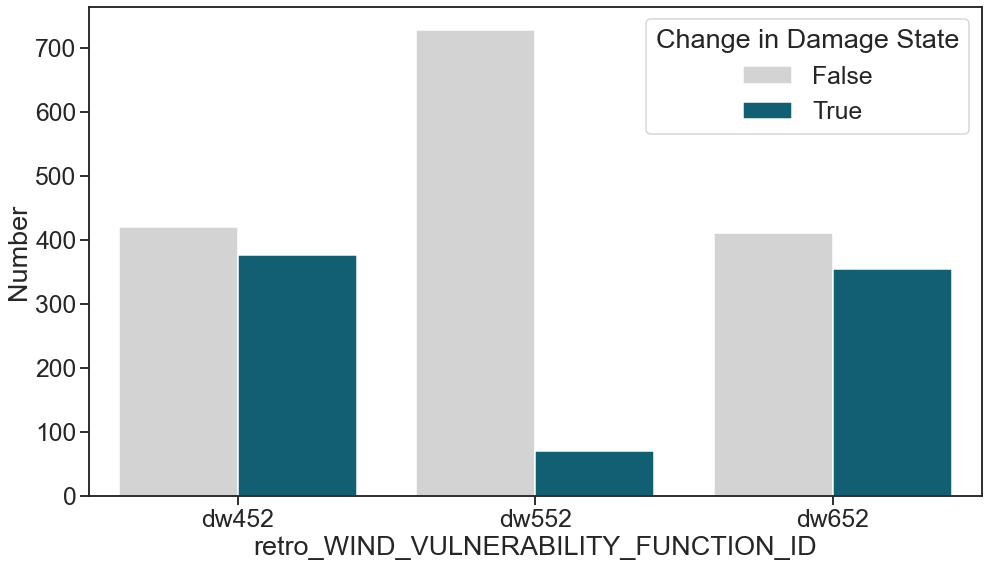

In [159]:
# labels for retrofit vuln functions (legacy retrofit functions)
labels2 = ['dw452','dw552','dw652']

# locating buildings with baseline vuln func dw352
dw352 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw352'))]
dw352 = dw352.loc[~((dw352['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw352'))]
dw352.name = 'dw352'
dw352['plot'] = dw352['retro_WIND_VULNERABILITY_FUNCTION_ID'].astype(str) + ' ' + dw352['wind_bins'].astype(str)

# plot of change in damage state (true or false) for change in vuln func
# dw352 to dw452, dw552, dw652
fig, ax = plt.subplots(figsize=(16,9))
ax = sns.countplot(x='retro_WIND_VULNERABILITY_FUNCTION_ID',order=labels2, data=dw352, hue='dif_DS', palette=["#D3D3D3","#006983"])
ax.legend(title="Change in Damage State", frameon=True, loc=1)
ax.set_ylabel("Number")
fig.savefig(pjoin(data_path,
                  f"change_in_DS_by_vuln_func_3".format(fmt)), dpi=res)


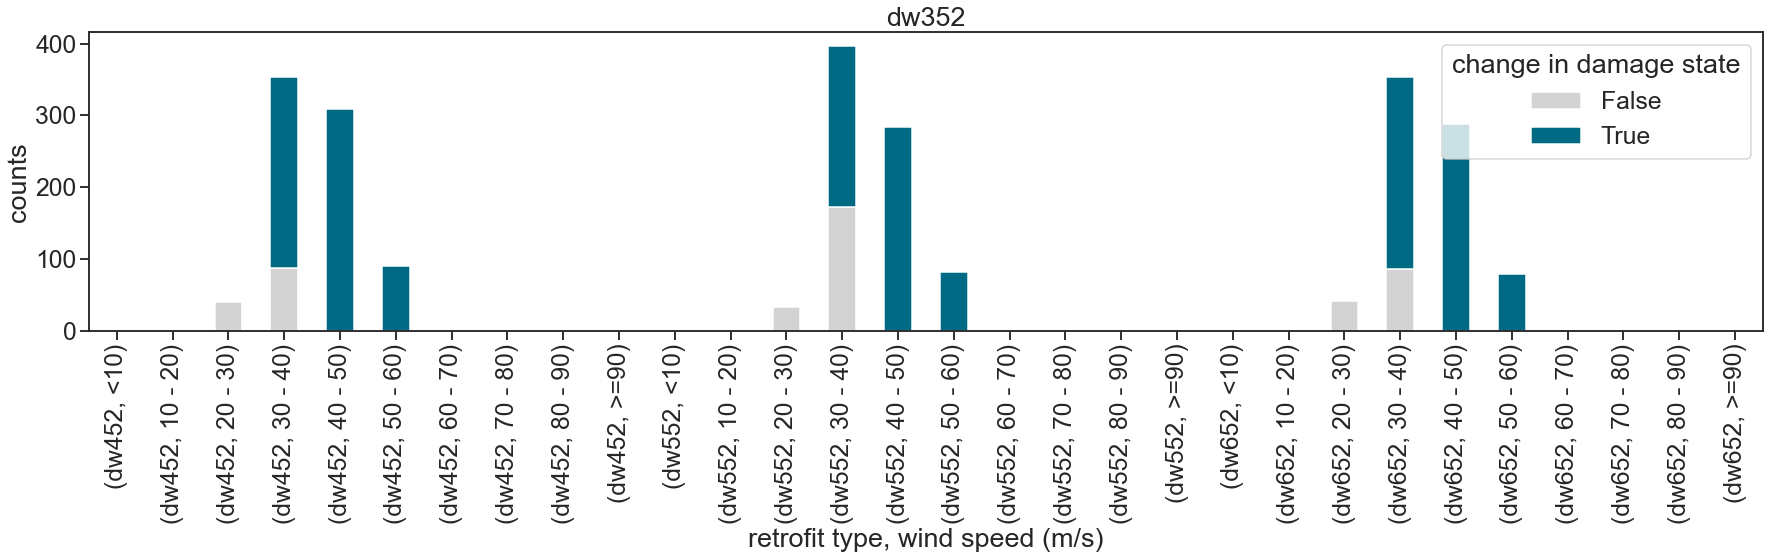

In [160]:
# comparison of change in damage state (true or false) and change in vuln func
# by wind speed
fig,ax = plt.subplots(1,1,figsize=(30,5.5))
dw352_DS_wind = dw352.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index().pivot(columns='dif_struc', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)
dw352_DS_wind.plot(kind='bar',stacked=True, color=["#D3D3D3","#006983"], ax=ax)
plt.title('dw352')
plt.xlabel('retrofit type, wind speed (m/s)')
plt.ylabel('counts')
plt.legend(title='change in damage state')
plt.savefig(pjoin(data_path,
                  f"change_in_DS_by_vuln_func_bins_dw352".format(fmt)), dpi=res, bbox_inches = 'tight')

In [161]:
# creating seperate dfs for each vuln func change legacy retrofit
dw350 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw350'))]
dw350_450 = dw350.loc[((dw350['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw450'))]
dw350_550 = dw350.loc[((dw350['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw550'))]
dw350_650 = dw350.loc[((dw350['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw650'))]
dw350_450_DS_wind = dw350_450.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw350_450_DS_wind.columns = [*dw350_450_DS_wind.columns[:-1], 'count']
dw350_450_DS_wind = (dw350_450_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )
dw350_550_DS_wind = dw350_550.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw350_550_DS_wind.columns = [*dw350_550_DS_wind.columns[:-1], 'count']
dw350_550_DS_wind = (dw350_550_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )
dw350_650_DS_wind = dw350_650.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw350_650_DS_wind.columns = [*dw350_650_DS_wind.columns[:-1], 'count']
dw350_650_DS_wind = (dw350_650_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )

dw351 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw351'))]
dw351_451 = dw351.loc[((dw351['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw451'))]
dw351_551 = dw351.loc[((dw351['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw551'))]
dw351_651 = dw351.loc[((dw351['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw651'))]
dw351_451_DS_wind = dw351_451.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw351_451_DS_wind.columns = [*dw351_451_DS_wind.columns[:-1], 'count']
dw351_451_DS_wind = (dw351_451_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )
dw351_551_DS_wind = dw351_551.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw351_551_DS_wind.columns = [*dw351_551_DS_wind.columns[:-1], 'count']
dw351_551_DS_wind = (dw351_551_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )
dw351_651_DS_wind = dw351_651.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw351_651_DS_wind.columns = [*dw351_651_DS_wind.columns[:-1], 'count']
dw351_651_DS_wind = (dw351_651_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )

dw352 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw352'))]
dw352_452 = dw352.loc[((dw352['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw452'))]
dw352_552 = dw352.loc[((dw352['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw552'))]
dw352_652 = dw352.loc[((dw352['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw652'))]
dw352_452_DS_wind = dw352_452.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw352_452_DS_wind.columns = [*dw352_452_DS_wind.columns[:-1], 'count']
dw352_452_DS_wind = (dw352_452_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )
dw352_552_DS_wind = dw352_552.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw352_552_DS_wind.columns = [*dw352_552_DS_wind.columns[:-1], 'count']
dw352_552_DS_wind = (dw352_552_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )
dw352_652_DS_wind = dw352_652.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_struc']).size().reset_index()
dw352_652_DS_wind.columns = [*dw352_652_DS_wind.columns[:-1], 'count']
dw352_652_DS_wind = (dw352_652_DS_wind.set_index(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'])
        .pivot(columns='dif_struc')['count']
        .reset_index()
         )

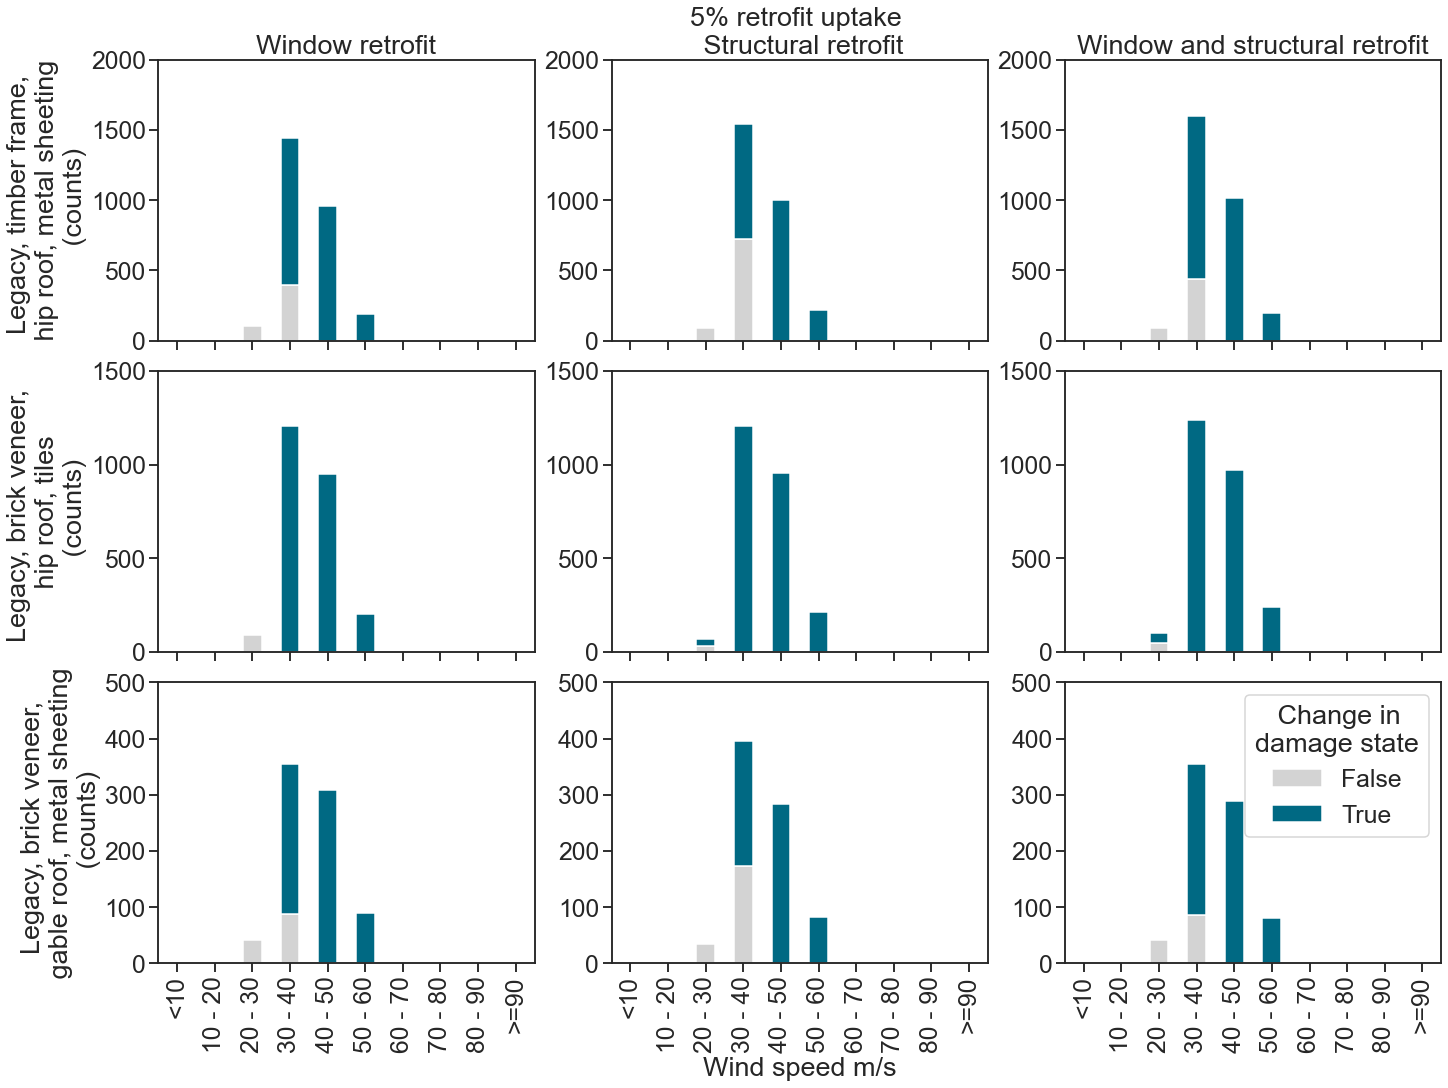

In [162]:
# plotting change in vuln func and damage state by wind speed
fig, ax = plt.subplots(nrows = 3, ncols = 3,figsize=(20,15),constrained_layout=True,sharex=True)
l1 = dw350_450_DS_wind.plot(ax=ax[0,0],kind='bar',stacked=True,legend=False,ylim=(0,2000),color=["#D3D3D3","#006983"],title='Window retrofit',ylabel='Legacy, timber frame, \n hip roof, metal sheeting \n (counts)')
l2 = dw350_550_DS_wind.plot(ax=ax[0,1],kind='bar',stacked=True,legend=False,ylim=(0,2000),color=["#D3D3D3","#006983"],title= Title + ' \n Structural retrofit')
l3 = dw350_650_DS_wind.plot(ax=ax[0,2],kind='bar',stacked=True,legend=False,ylim=(0,2000),color=["#D3D3D3","#006983"],title='Window and structural retrofit')
l4 = dw351_451_DS_wind.plot(ax=ax[1,0],kind='bar',stacked=True,legend=False,ylim=(0,1500),color=["#D3D3D3","#006983"],ylabel='Legacy, brick veneer, \n hip roof, tiles \n (counts)')
l5 = dw351_551_DS_wind.plot(ax=ax[1,1],kind='bar',stacked=True,legend=False,ylim=(0,1500),color=["#D3D3D3","#006983"])
l6 = dw351_651_DS_wind.plot(ax=ax[1,2],kind='bar',stacked=True,legend=False,ylim=(0,1500),color=["#D3D3D3","#006983"])
l7 = dw352_452_DS_wind.plot(ax=ax[2,0],kind='bar',stacked=True,legend=False,ylim=(0,500),color=["#D3D3D3","#006983"],ylabel='Legacy, brick veneer, \n gable roof, metal sheeting \n (counts)')
l8 = dw352_552_DS_wind.plot(ax=ax[2,1],kind='bar',stacked=True,legend=False,ylim=(0,500),color=["#D3D3D3","#006983"])
l9 = dw352_652_DS_wind.plot(ax=ax[2,2],kind='bar',stacked=True,ylim=(0,500),color=["#D3D3D3","#006983"])
ax[2,2].legend(title='   Change in  \ndamage state')
ax[2,2].set_xticklabels(wind_labels)
ax[2,1].set_xlabel('Wind speed m/s')
ax[2,0].set_xlabel('')
ax[2,2].set_xlabel('')
fig.savefig(pjoin(data_path,
                  f"old_buildings_retrofit_wind_DS_count".format(fmt)), dpi=res)

In [163]:
# creating seperate dfs for each vuln func change modern retrofit
dw353 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw353'))]
dw353_453 = dw353.loc[((dw353['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw453'))]
dw353_453_DS_wind = dw353_453.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw354 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw354'))]
dw354_454 = dw354.loc[((dw354['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw454'))]
dw354_454_DS_wind = dw354_454.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw355 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw355'))]
dw355_455 = dw355.loc[((dw355['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw455'))]
dw355_455_DS_wind = dw355_455.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw356 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw356'))]
dw356_456 = dw356.loc[((dw356['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw456'))]
dw356_456_DS_wind = dw356_456.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw357 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw357'))]
dw357_457 = dw357.loc[((dw357['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw457'))]
dw357_457_DS_wind = dw357_457.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw358 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw358'))]
dw358_458 = dw358.loc[((dw358['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw458'))]
dw358_458_DS_wind = dw358_458.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw359 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw359'))]
dw359_459 = dw359.loc[((dw359['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw459'))]
dw359_459_DS_wind = dw359_459.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw360 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw360'))]
dw360_460 = dw360.loc[((dw360['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw460'))]
dw360_460_DS_wind = dw360_460.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw361 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw361'))]
dw361_461 = dw361.loc[((dw361['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw461'))]
dw361_461_DS_wind = dw361_461.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw362 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw362'))]
dw362_462 = dw362.loc[((dw362['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw462'))]
dw362_462_DS_wind = dw362_462.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw363 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw363'))]
dw363_463 = dw363.loc[((dw363['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw463'))]
dw363_463_DS_wind = dw363_463.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

dw364 = Retro_comp_all.loc[((Retro_comp_all['none_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw364'))]
dw364_464 = dw364.loc[((dw364['retro_WIND_VULNERABILITY_FUNCTION_ID'] == 'dw464'))]
dw364_464_DS_wind = dw364_464.groupby(['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins','dif_DS']).size().reset_index().pivot(columns='dif_DS', index=['retro_WIND_VULNERABILITY_FUNCTION_ID','wind_bins'], values=0)

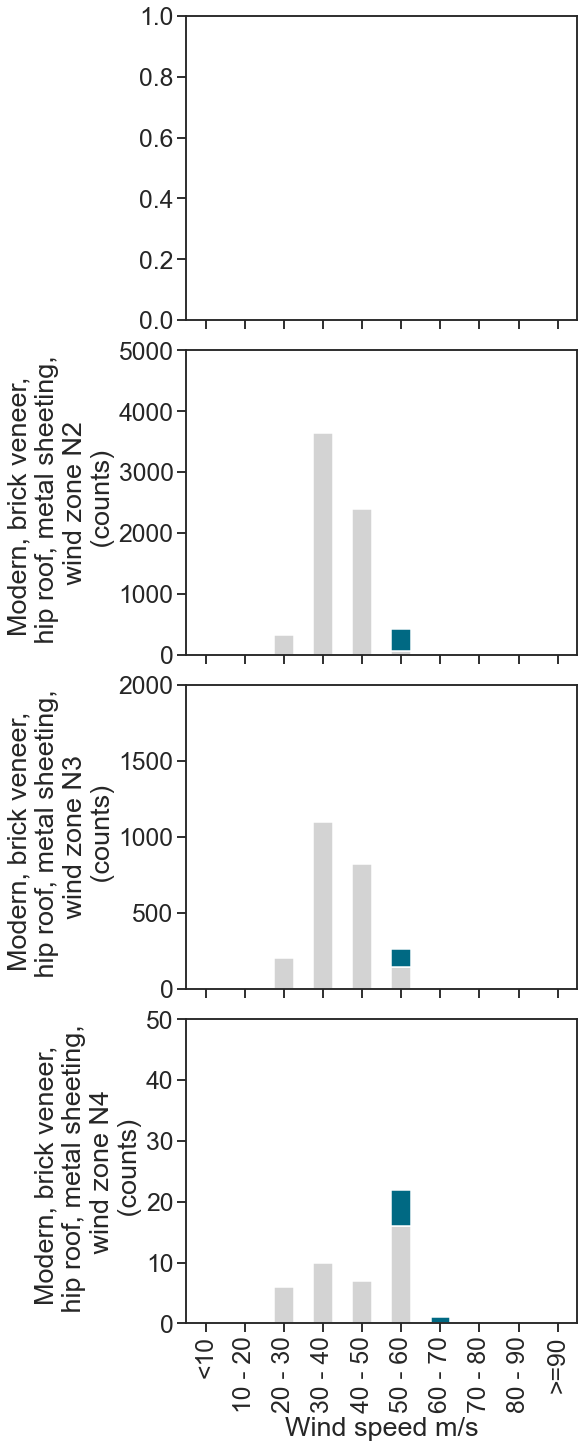

In [164]:
# plotting change in vuln func and damage state by wind speed (modern buildings)
# if there is no data turn off the graph for which there is no data
fig, ax = plt.subplots(nrows = 4, ncols = 1,figsize=(8,20),constrained_layout=True,sharex=True)
#p1 = dw353_453_DS_wind.plot(ax=ax[0],kind='bar',stacked=True,legend=False,ylim=(0,500),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, metal sheeting,\n wind zone N1 \n (counts)')
p2 = dw354_454_DS_wind.plot(ax=ax[1],kind='bar',stacked=True,legend=False,ylim=(0,5000),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, metal sheeting,\n wind zone N2 \n (counts)')
p3 = dw355_455_DS_wind.plot(ax=ax[2],kind='bar',stacked=True,legend=False,ylim=(0,2000),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, metal sheeting,\n wind zone N3 \n (counts)')
p4 = dw356_456_DS_wind.plot(ax=ax[3],kind='bar',stacked=True,legend=False,ylim=(0,50),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, metal sheeting,\n wind zone N4 \n (counts)')
ax[3].set_xticklabels(wind_labels)
ax[3].set_xlabel('Wind speed m/s')
fig.savefig(pjoin(data_path,
                  f"new_buildings_retrofit_wind_DS_count_1".format(fmt)), dpi=res)

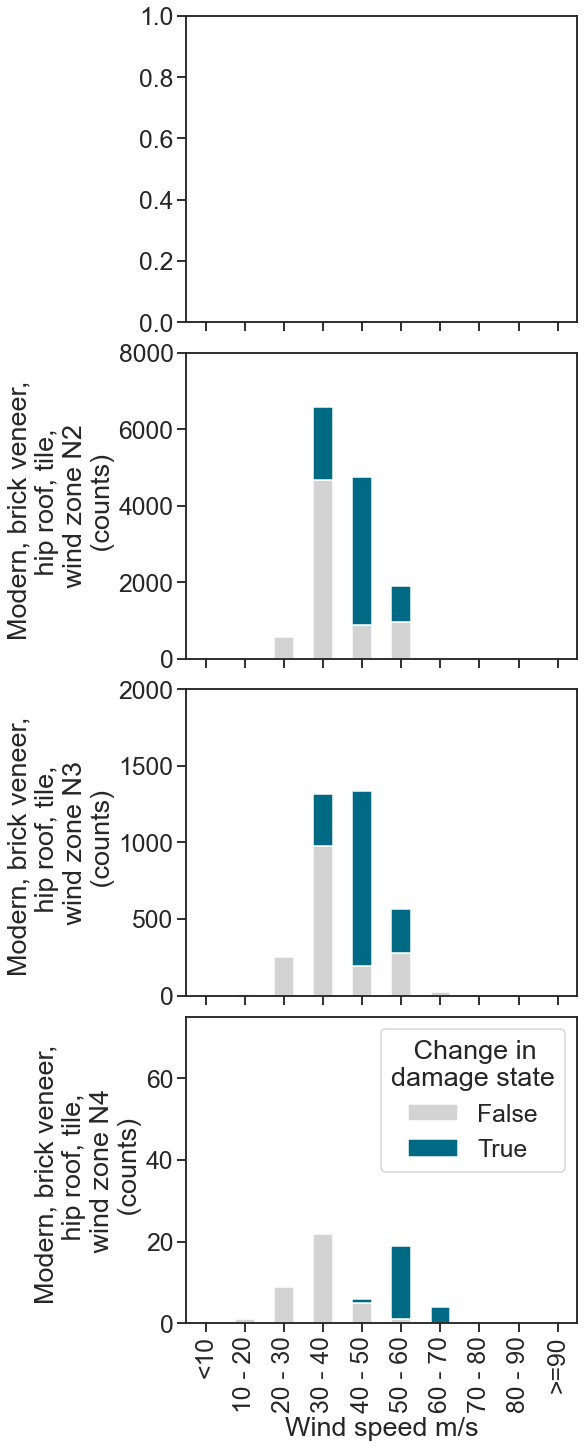

In [165]:
# plotting change in vuln func and damage state by wind speed (modern buildings)
# if there is no data turn off the graph for which there is no data
fig, ax = plt.subplots(nrows = 4, ncols = 1,figsize=(8,20),constrained_layout=True,sharex=True)
#p5 = dw359_459_DS_wind.plot(ax=ax[0],kind='bar',stacked=True,legend=False,ylim=(0,250),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, tile,\n wind zone N1 \n (counts)')
p6 = dw360_460_DS_wind.plot(ax=ax[1],kind='bar',stacked=True,legend=False,ylim=(0,8000),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, tile,\n wind zone N2 \n (counts)')
p7 = dw361_461_DS_wind.plot(ax=ax[2],kind='bar',stacked=True,legend=False,ylim=(0,2000),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, tile,\n wind zone N3 \n (counts)')
p8 = dw362_462_DS_wind.plot(ax=ax[3],kind='bar',stacked=True,ylim=(0,75),color=["#D3D3D3","#006983"],ylabel='Modern, brick veneer, \n hip roof, tile,\n wind zone N4 \n (counts)')
ax[3].legend(title='   Change in  \ndamage state')
ax[3].set_xticklabels(wind_labels)
ax[3].set_xlabel('Wind speed m/s')
fig.savefig(pjoin(data_path,
                  f"new_buildings_retrofit_wind_DS_count_2".format(fmt)), dpi=res)